In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy as sp

import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

from scipy import stats

from tqdm import tqdm

from sklearn.datasets import load_boston

from sklearn.datasets import load_iris

from sklearn.datasets import load_diabetes

from sklearn.datasets import load_wine

import pickle

#Mylib
import Ordering as OD
import StatTests as st
import Model as md

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

# Построение поверхности

In [3]:
def function(X_train, X_test, y_train, y_test, 
             model = [md.LinearRegress, md.log_likelihood_regression], 
             position = None, k_for_meaning = 100, sigma = 1.0, print_progres = False):
    if position is None:
        position = np.linspace(X_train.shape[1], X_train.shape[0] - 1, num = 100, dtype=np.int64)

    cov = (sigma**2)*np.eye(y_test.shape[0])
    
    List_of_error_mean = []
    List_of_error_std = []
    if print_progres:
        list_position = tqdm(position)
    else:
        list_position = position
    for size in list_position:
        List_of_error_for_k = []
        for k in range(k_for_meaning):
            indexes = np.random.permutation(X_train.shape[0])[:size]
            W = model[0](X_train[indexes, :], y_train[indexes])
            List_of_error_for_k.append(model[1](X_test@W, cov, y_test))
            
        List_of_error_mean.append(np.mean(List_of_error_for_k))
        List_of_error_std.append(np.std(List_of_error_for_k))
        
    return List_of_error_mean, List_of_error_std

def get_surface(X_train, X_test, y_train, y_test, linear_model = 'LinearRegression',
             ordering = None, position = None, k_for_meaning = 100, sigma = 1.0, print_progres = False):
    if position is None:
        position = np.linspace(X_train.shape[1], X_train.shape[0] - 1, num = 100, dtype=np.int64)
    if ordering is None:
        ordering = OD.features_ordering(X_train, y_train, linear_model=linear_model)
        
    if linear_model == 'LinearRegression':
        model = [md.LinearRegress, md.log_likelihood_regression]
    elif linear_model == 'LogisticRegression':
        model = [md.LogisticRegress, md.log_likelihood_logistic]
        
    List_of_graphs_mean = []
    List_of_graphs_std = []
    
    if print_progres:
        list_ordering = tqdm(range(X_train.shape[1] - 1))
    else:
        list_ordering = range(X_train.shape[1] - 1)
    
    for count_of_features in list_ordering:
        mask = np.ones(X_train.shape[1])
        mask[ordering < count_of_features] = 0
        mean, std = function(X_train[:, mask == 1], X_test[:, mask == 1], y_train, y_test, 
                             position=position, sigma = sigma,
                             k_for_meaning=k_for_meaning, model=model)
        List_of_graphs_mean.append(mean)
        List_of_graphs_std.append(std)
        
    return List_of_graphs_mean, List_of_graphs_std

# Базовый эксперимент

## Synthetic data

### Example 1

In [4]:
np.random.seed(0)

n = 10
l = 100
X = np.random.rand(l, n)
w = np.random.rand(n)*np.random.randint(0, 2, n)*100

for i in range(w.shape[0]):
    w[i] *= (-1)**i

sigma = 1.0
y = X@w + np.random.normal(loc = 0.0, scale = sigma**2, size = l)

X = scale(X)
y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75, 10) (25, 10) (75,) (25,)


In [5]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [0.92354221 0.49539358 0.30633061 0.8457011  0.6729785  0.20019344
 0.51966238 0.75017972 0.79951164 0.96482494]


In [6]:
ordering = OD.features_ordering(X_train, y_train)

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = 100, dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LinearRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/synthetic5000_1.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/synthetic5000_1.p", "rb"))


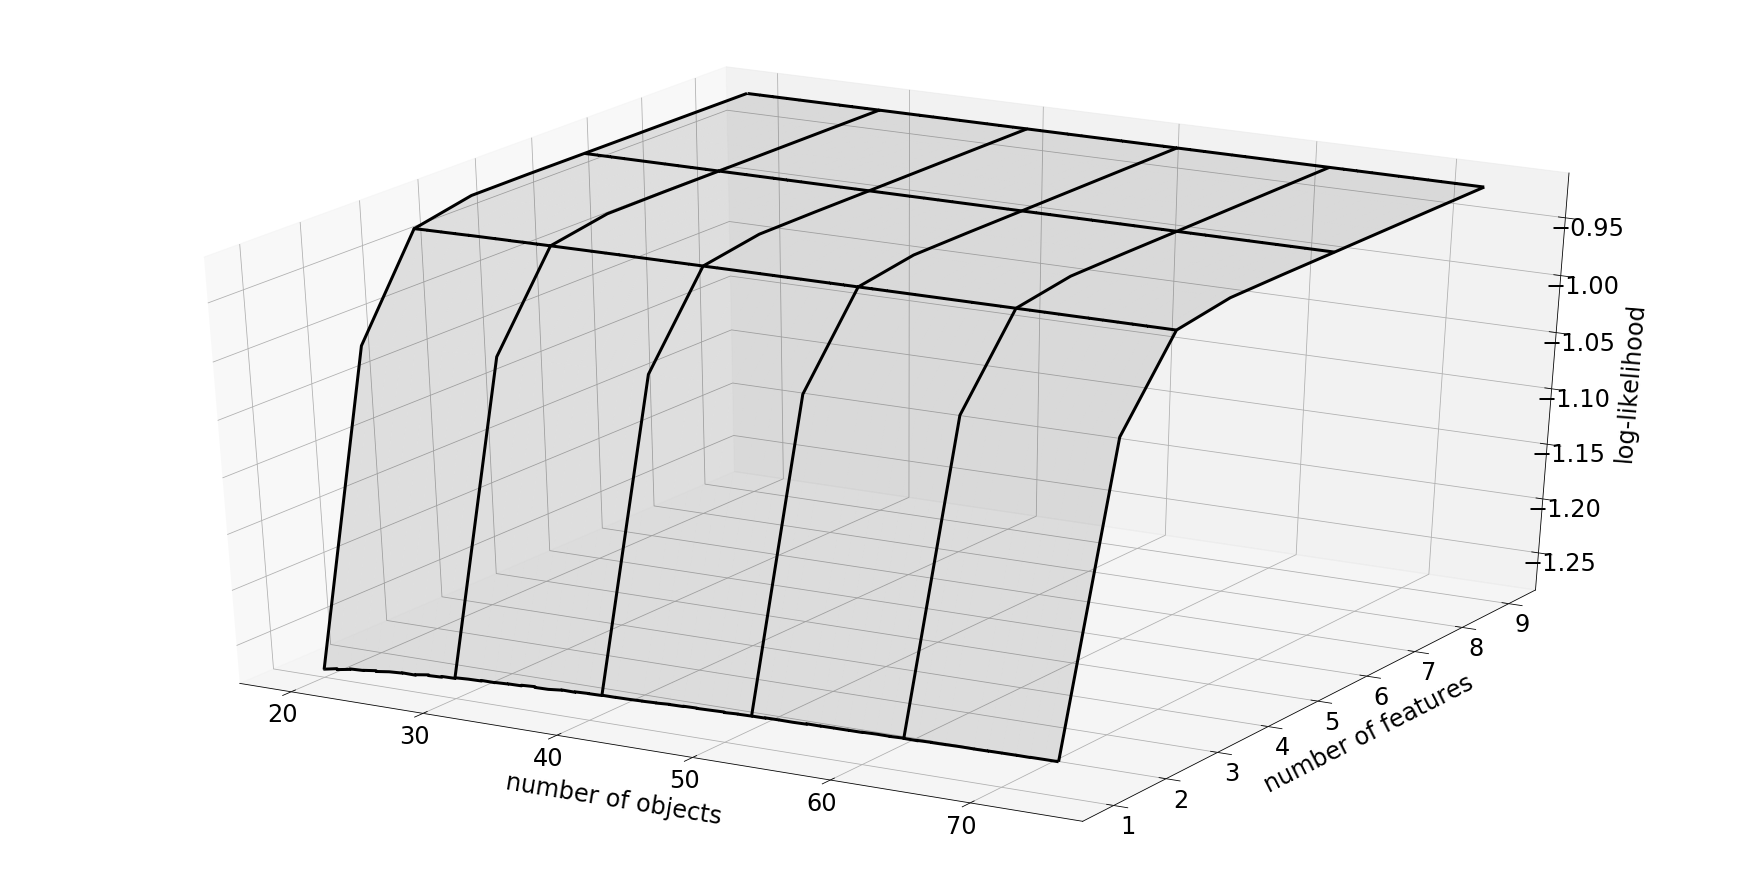

In [7]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=3, cstride=20, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.show()


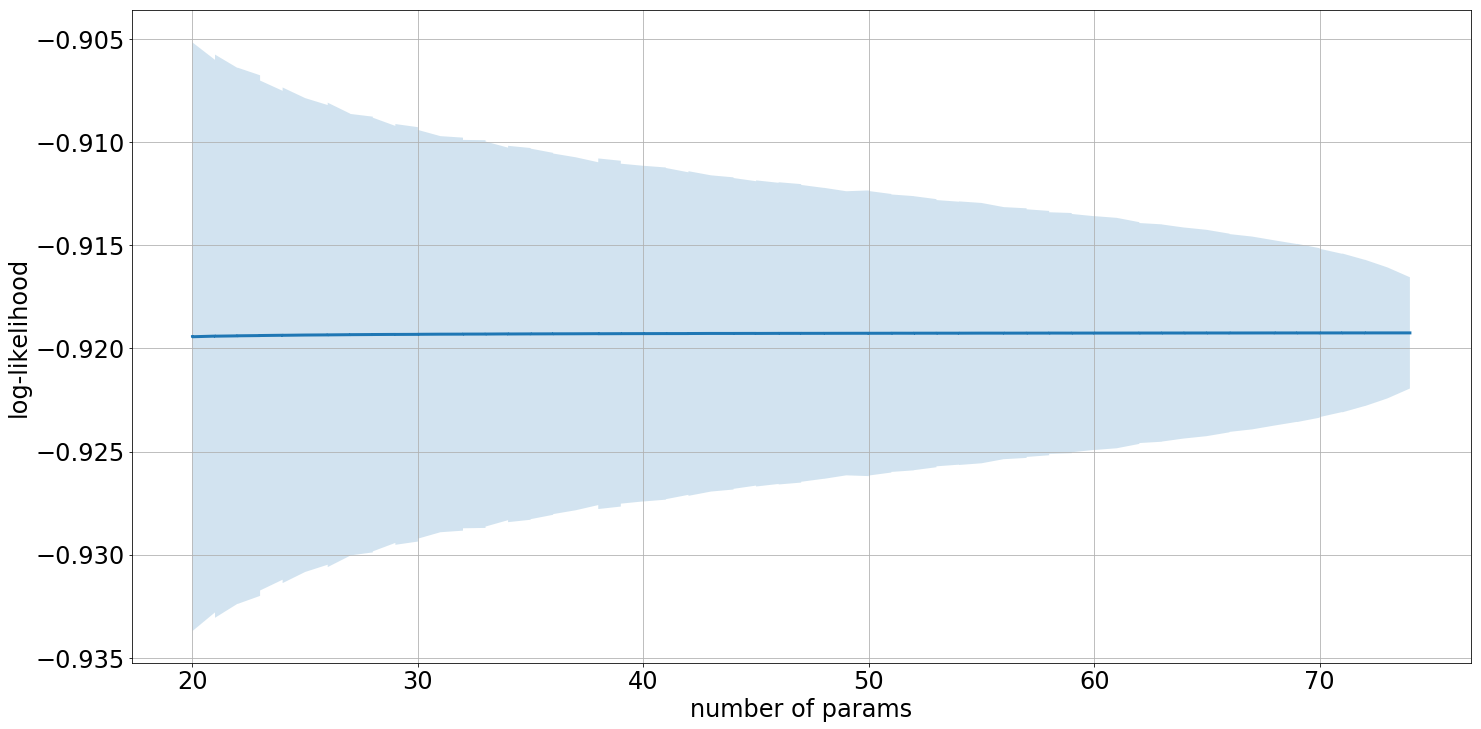

In [8]:
N = 0
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()

### Example 2

In [9]:
np.random.seed(0)

n = 10
l = 100
X = np.random.rand(l, n)
w = np.random.rand(n)*np.random.randint(0, 2, n)*100

for i in range(w.shape[0]):
    w[i] *= (-1)**i

sigma = 1.0
y = 0.5*(np.sign(X@w + np.random.normal(loc = 0.0, scale = sigma**2, size = l)) + 1)

X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75, 10) (25, 10) (75,) (25,)


In [10]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [0.92354221 0.49539358 0.30633061 0.8457011  0.6729785  0.20019344
 0.51966238 0.75017972 0.79951164 0.96482494]


In [11]:
ordering = OD.features_ordering(X_train, y_train, linear_model = 'LogisticRegression', print_progres = True)

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = X_train.shape[0], dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LogisticRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/synthetic5000_2.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/synthetic5000_2.p", "rb"))


100%|██████████| 10/10 [00:00<00:00, 111.59it/s]


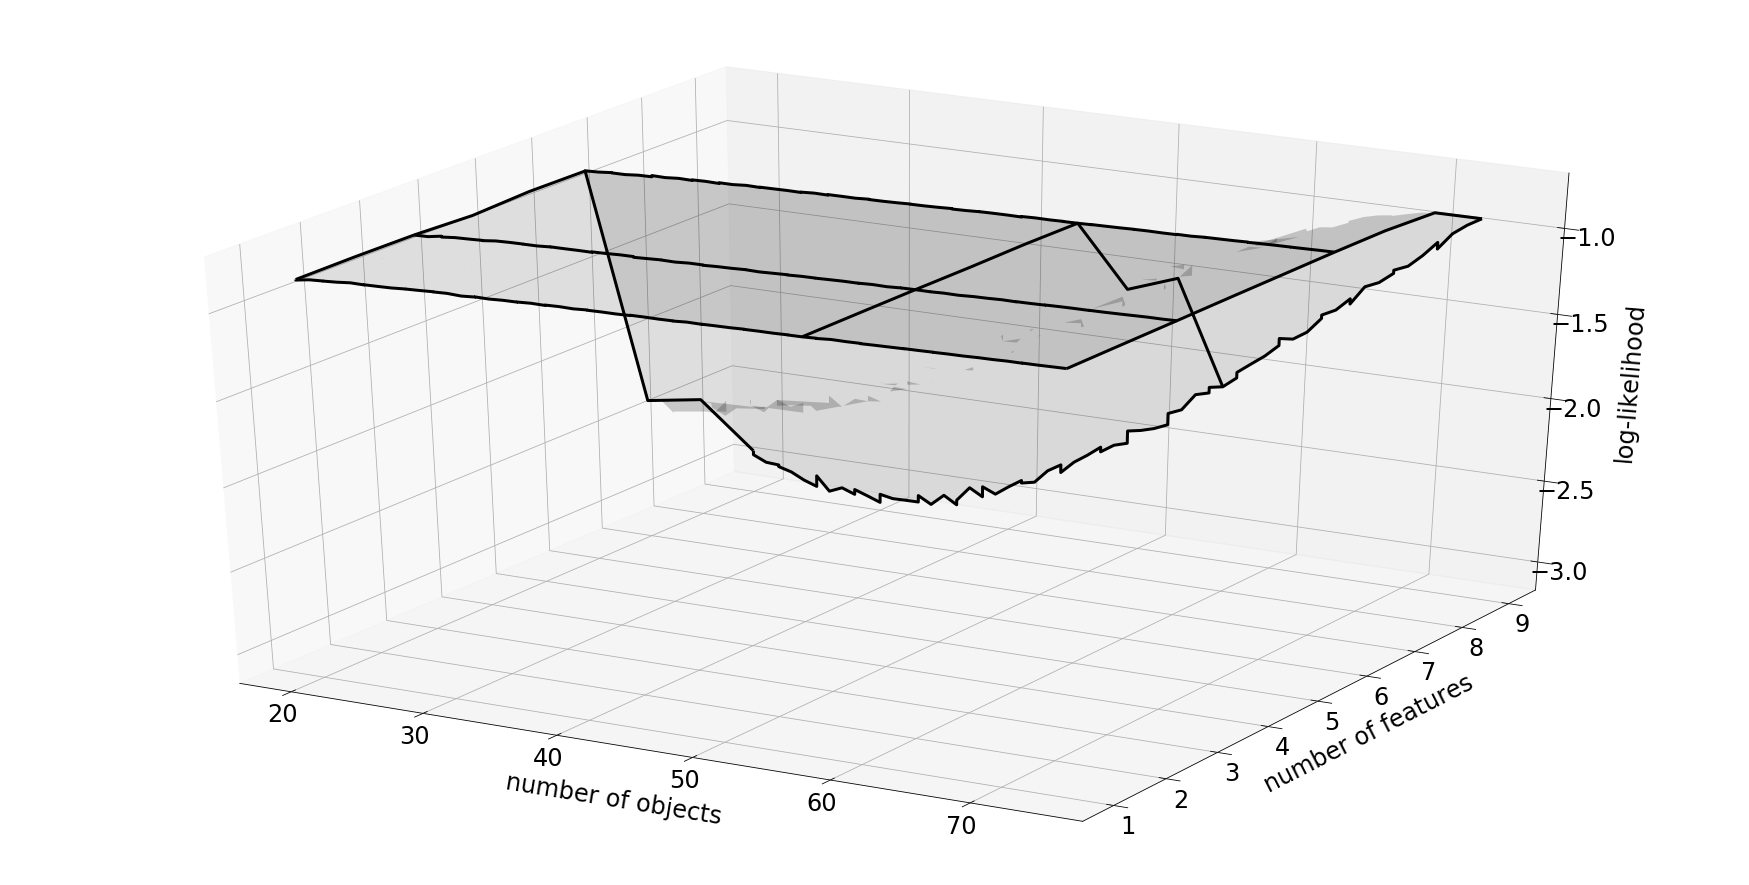

In [12]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=3, cstride=50, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.show()


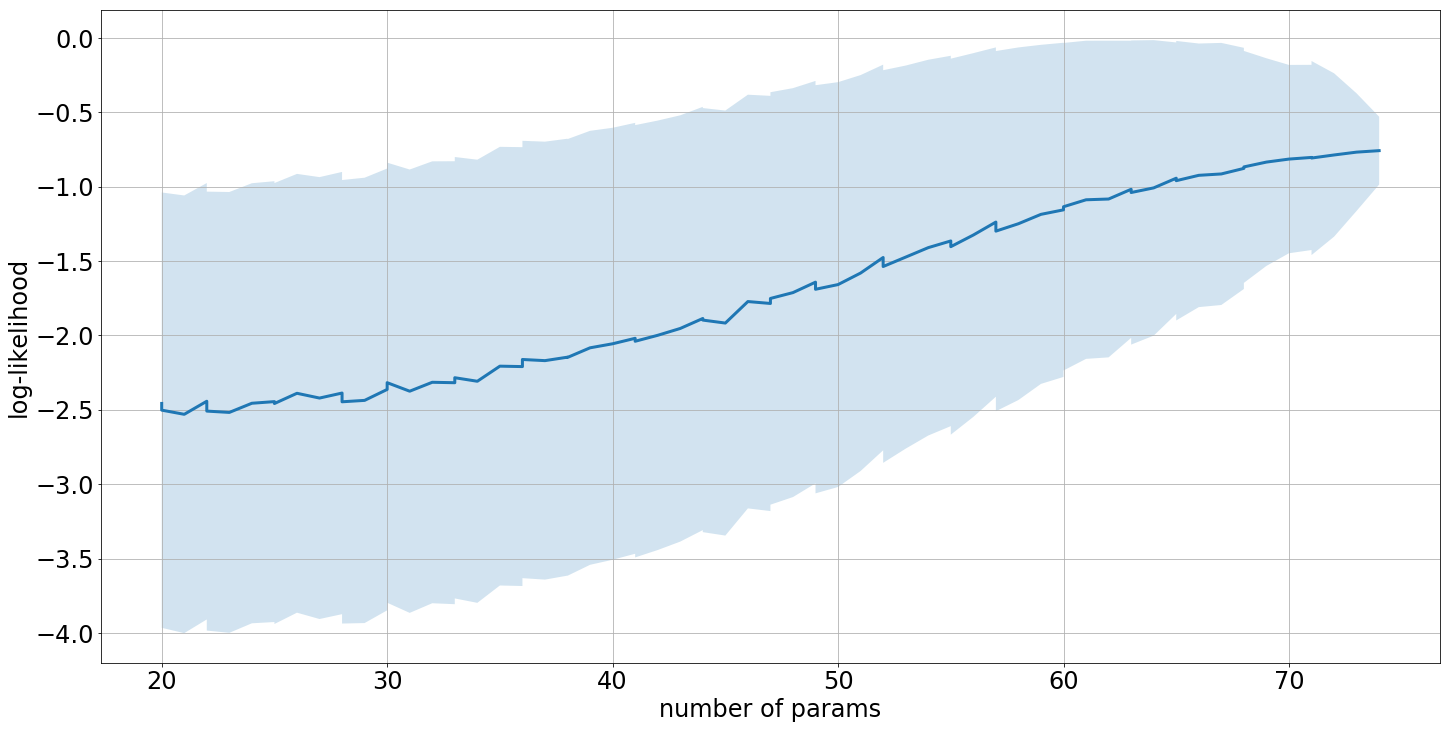

In [13]:
N = 1
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()


## Boston

In [51]:
np.random.seed(0)

dataset = load_boston()
observations = scale(dataset.data)
tg = scale(dataset.target)
data = pd.DataFrame(observations)

d = np.max(tg - np.min(tg))

m = np.min(tg)

data['Type'] = tg#(tg - m)/d

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train = shuffle(train)

y_test = test['Type'].values
y_test.reshape([-1])
del test['Type']
X_test = test.values

y_train = train['Type'].values
y_train.reshape([-1])
del train['Type']
X_train = train.values

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(407, 13) (99, 13) (407,) (99,)


In [52]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [0.00000000e+000 0.00000000e+000 7.39798675e-207 0.00000000e+000
 6.19325636e-052 4.19710990e-118 7.21450119e-043 8.21125193e-059
 0.00000000e+000 5.72214529e-273 4.49995134e-236 0.00000000e+000
 3.24439147e-045]


In [53]:
ordering = OD.features_ordering(X_train, y_train)

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = 350, dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LinearRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/boston5000.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/boston5000.p", "rb"))


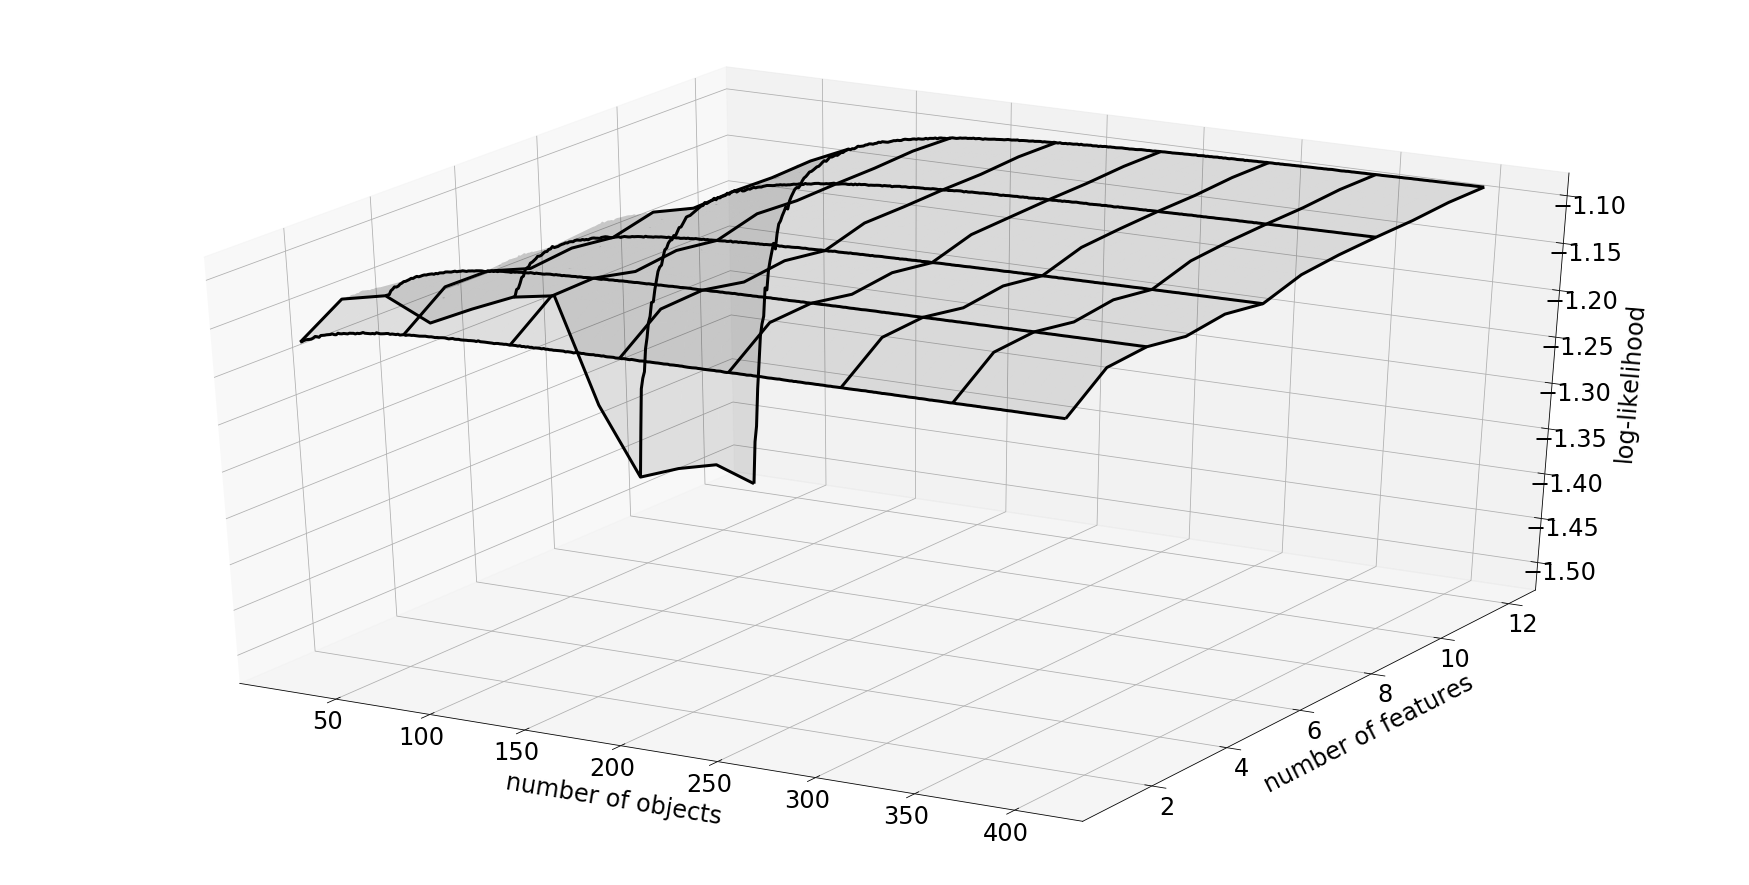

In [54]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=3, cstride=50, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.savefig("./figures/boston5000.pdf")
plt.show()


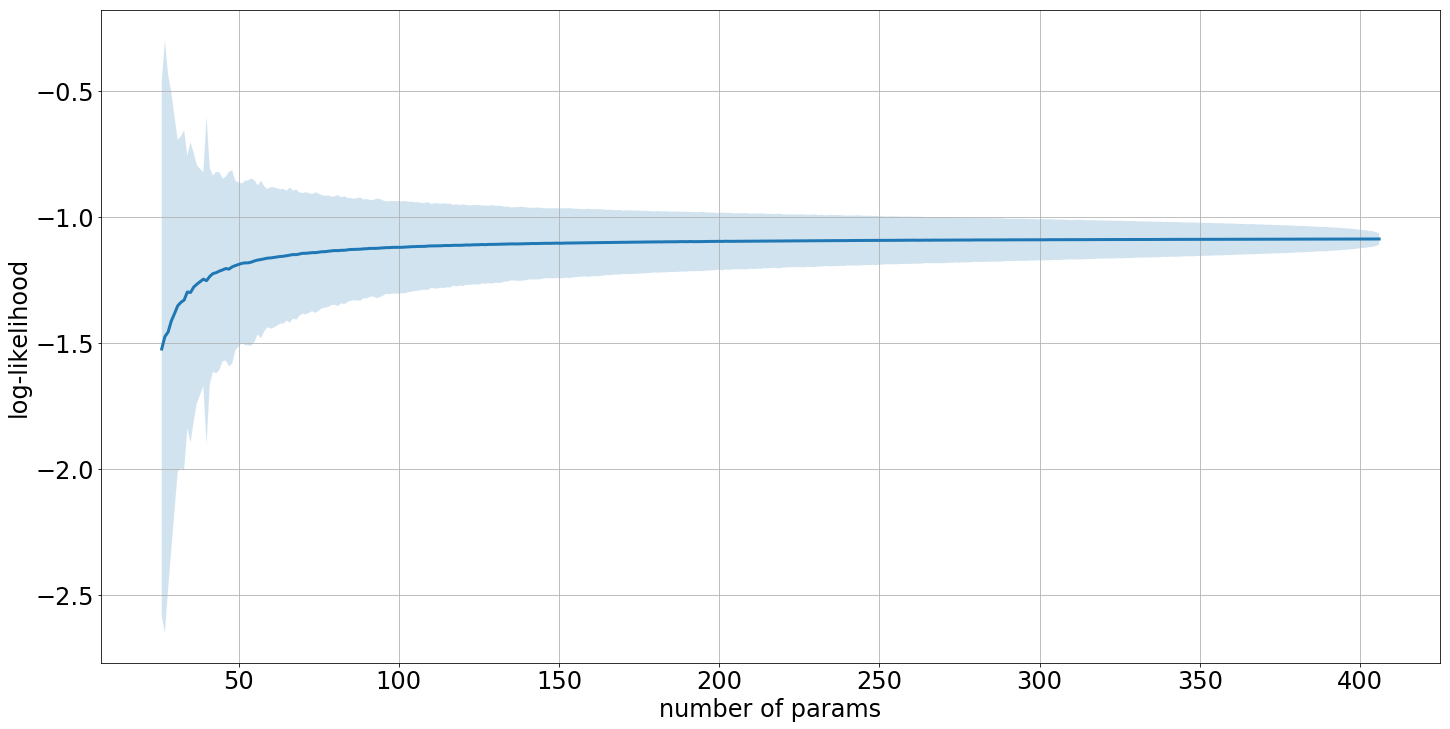

In [18]:
N = 0
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()

## Iris

In [19]:
np.random.seed(5)

dataset = load_iris()
observations = scale(dataset.data)
tg = dataset.target
data = pd.DataFrame(observations)

data['Type'] = tg#(tg - m)/d

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train = shuffle(train)

y_test = test['Type'].values
y_test.reshape([-1])
del test['Type']
X_test = test.values
X_test = np.delete(X_test, np.where(y_test == 2), axis = 0)
y_test = np.delete(y_test, np.where(y_test == 2), axis = 0)

y_train = train['Type'].values
y_train.reshape([-1])
del train['Type']
X_train = train.values
X_train = np.delete(X_train, np.where(y_train == 2), axis = 0)
y_train = np.delete(y_train, np.where(y_train == 2), axis = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(76, 4) (24, 4) (76,) (24,)


In [20]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [3.15563271e-02 2.83140647e-07 1.78328293e-11 8.14034744e-14]


In [21]:
ordering = OD.features_ordering(X_train, y_train, linear_model='LogisticRegression')

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = 100, dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LogisticRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/iris5000.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/iris5000.p", "rb"))


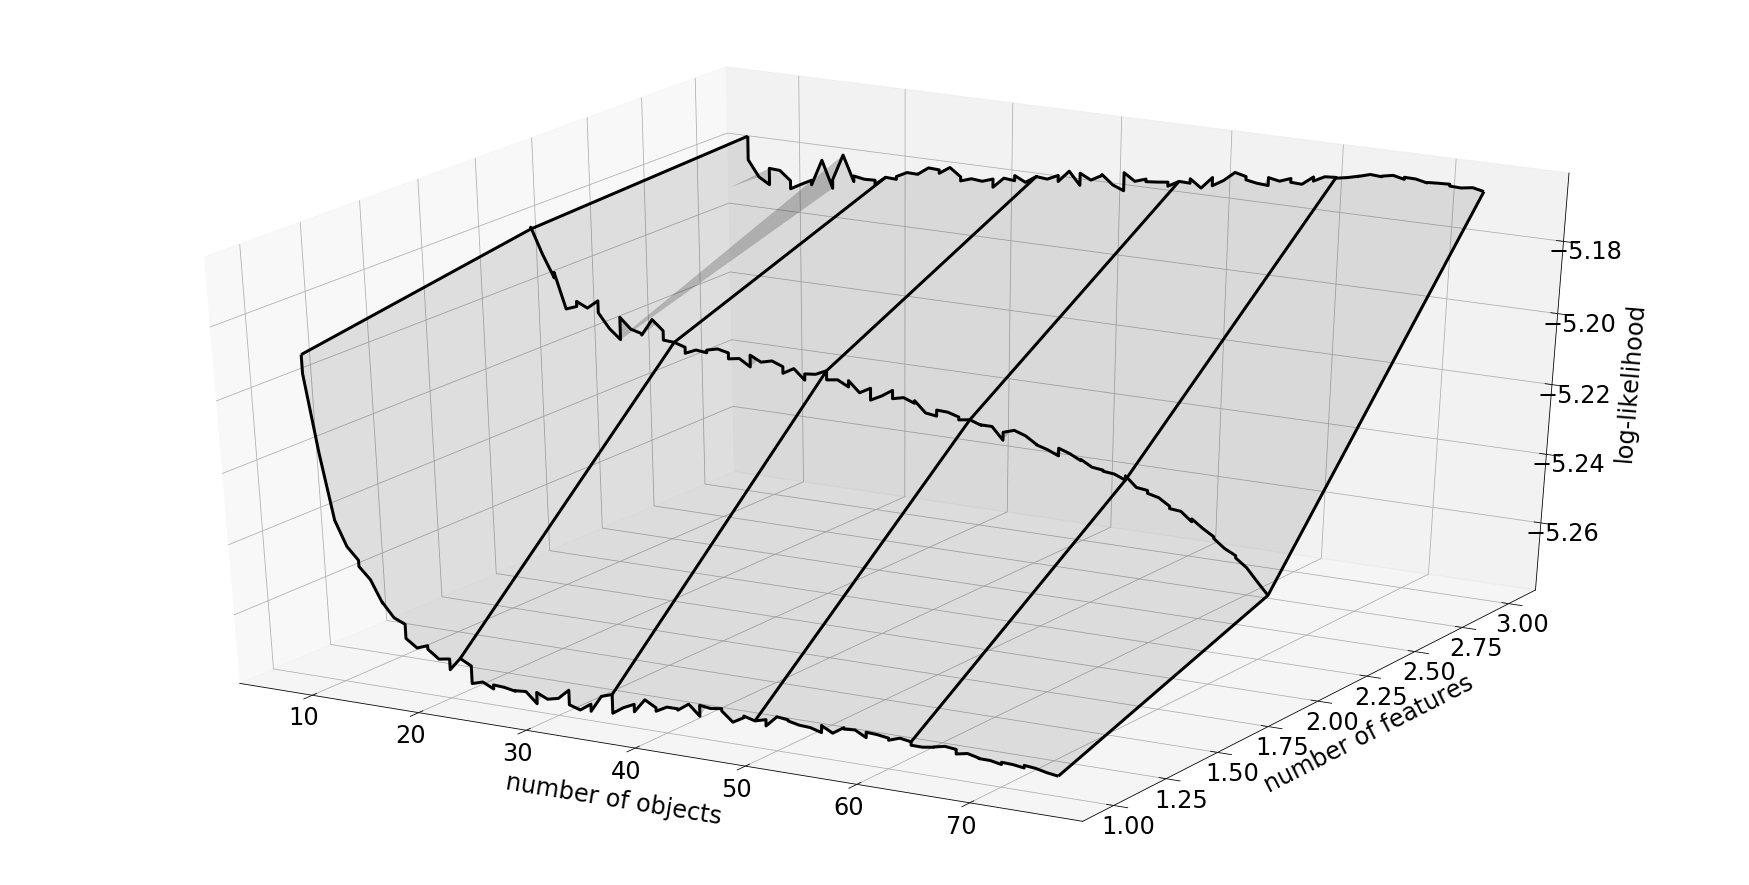

In [22]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=1, cstride=20, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.show()



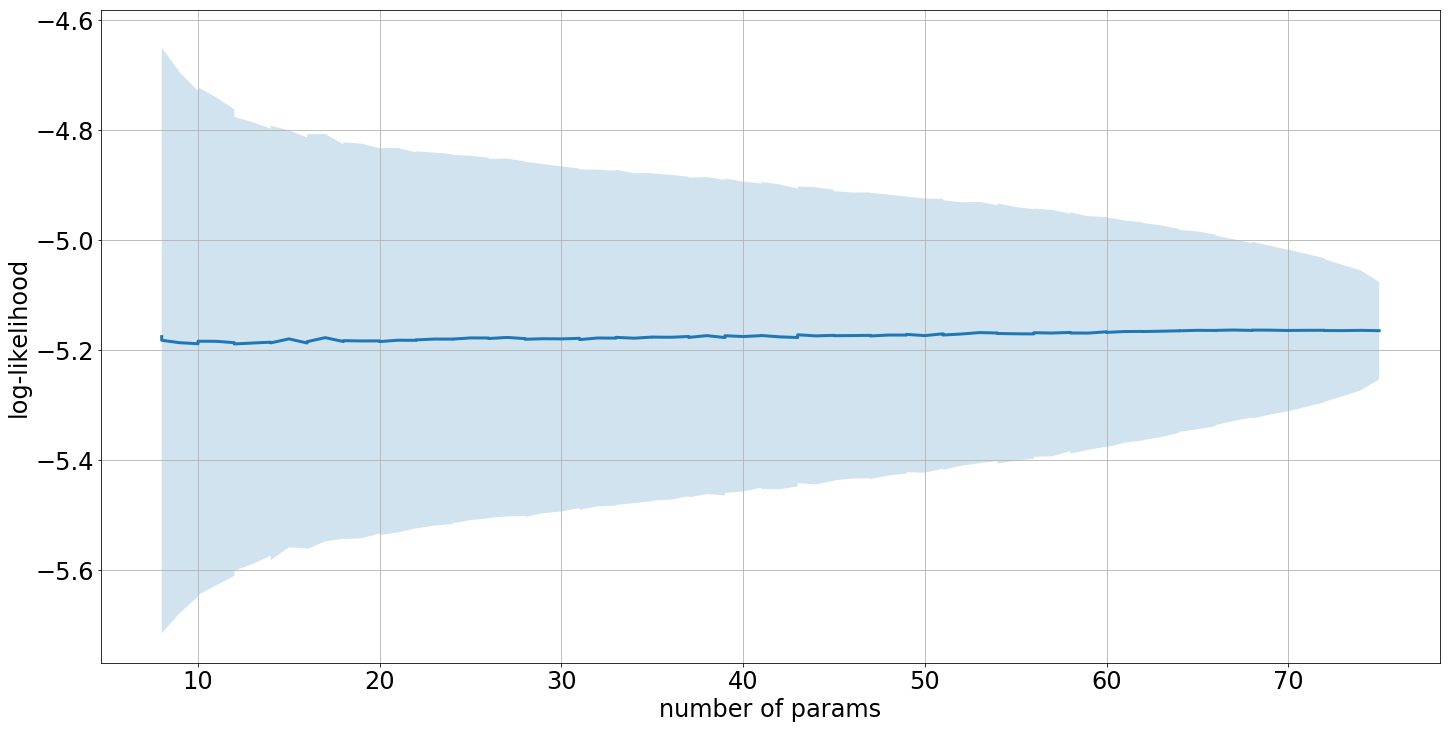

In [23]:
N = 0
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()

## Diabets

In [44]:
np.random.seed(0)

dataset = load_diabetes()
observations = scale(dataset.data)
tg = scale(dataset.target)
data = pd.DataFrame(observations)

d = np.max(tg - np.min(tg))

m = np.min(tg)

data['Type'] = tg#(tg - m)/d

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train = shuffle(train)

y_test = test['Type'].values
y_test.reshape([-1])
del test['Type']
X_test = test.values

y_train = train['Type'].values
y_train.reshape([-1])
del train['Type']
X_train = train.values

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(361, 10) (81, 10) (361,) (81,)


In [45]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [1.69074514e-21 0.00000000e+00 1.40997764e-33 2.30765378e-30
 7.18283256e-40 6.81315324e-57 1.18188636e-50 0.00000000e+00
 1.07729401e-25 2.91255831e-40]


In [46]:
ordering = OD.features_ordering(X_train, y_train)

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = 350, dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LinearRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/diabets5000.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/diabets5000.p", "rb"))


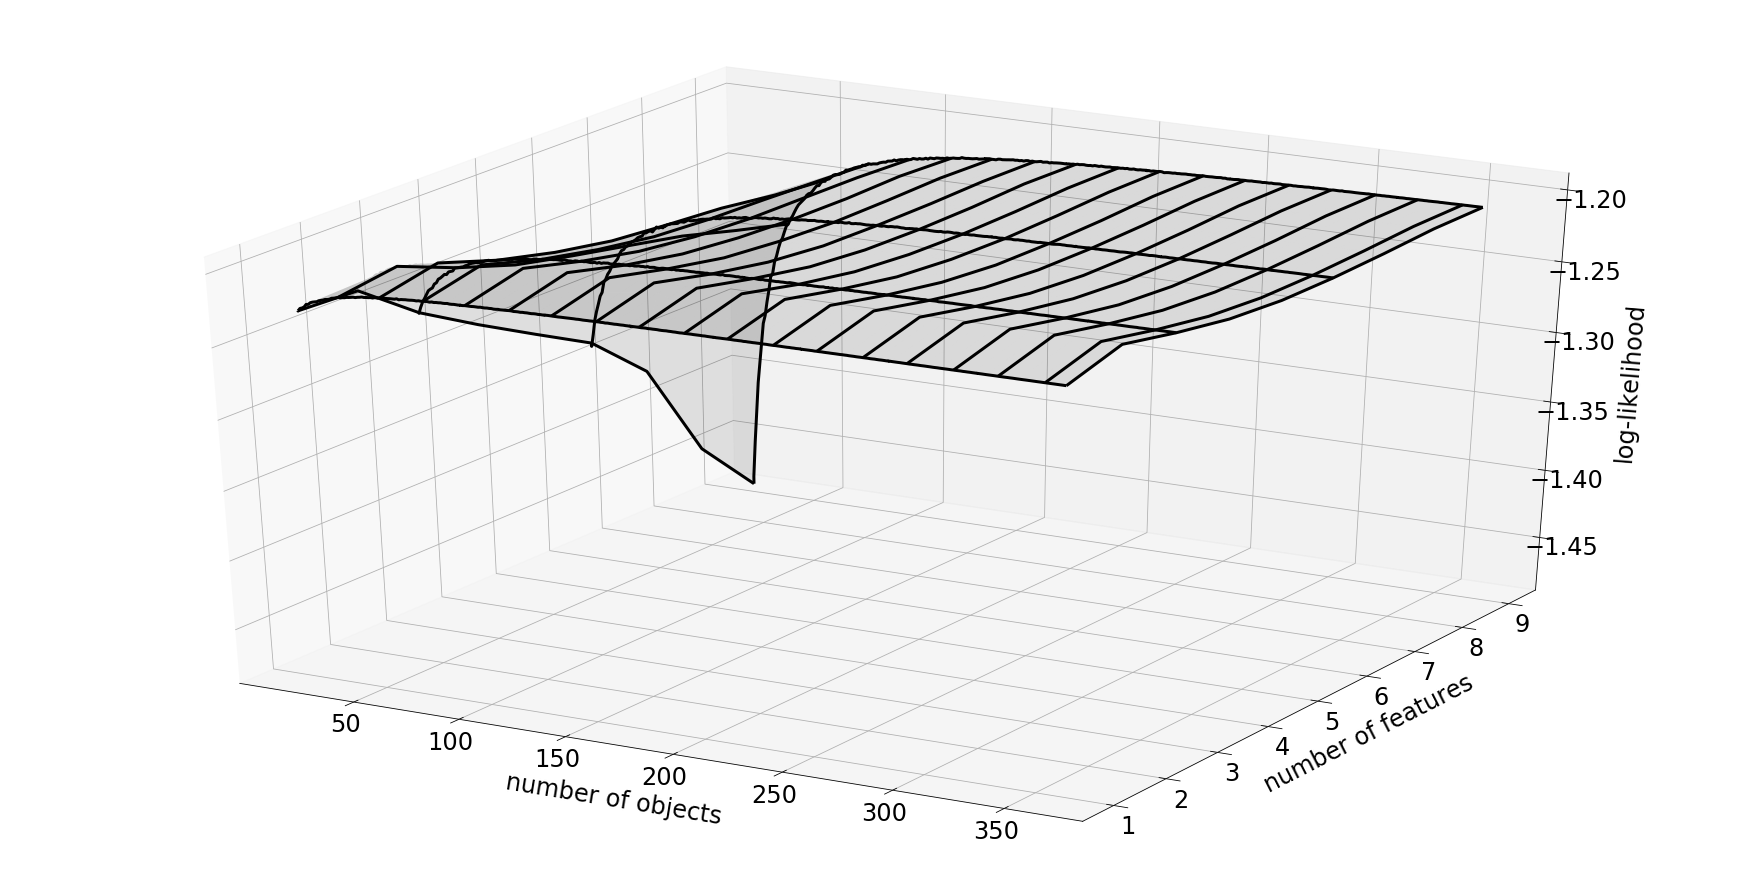

In [50]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=3, cstride=20, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.savefig("./figures/diabetes5000.pdf")
plt.show()



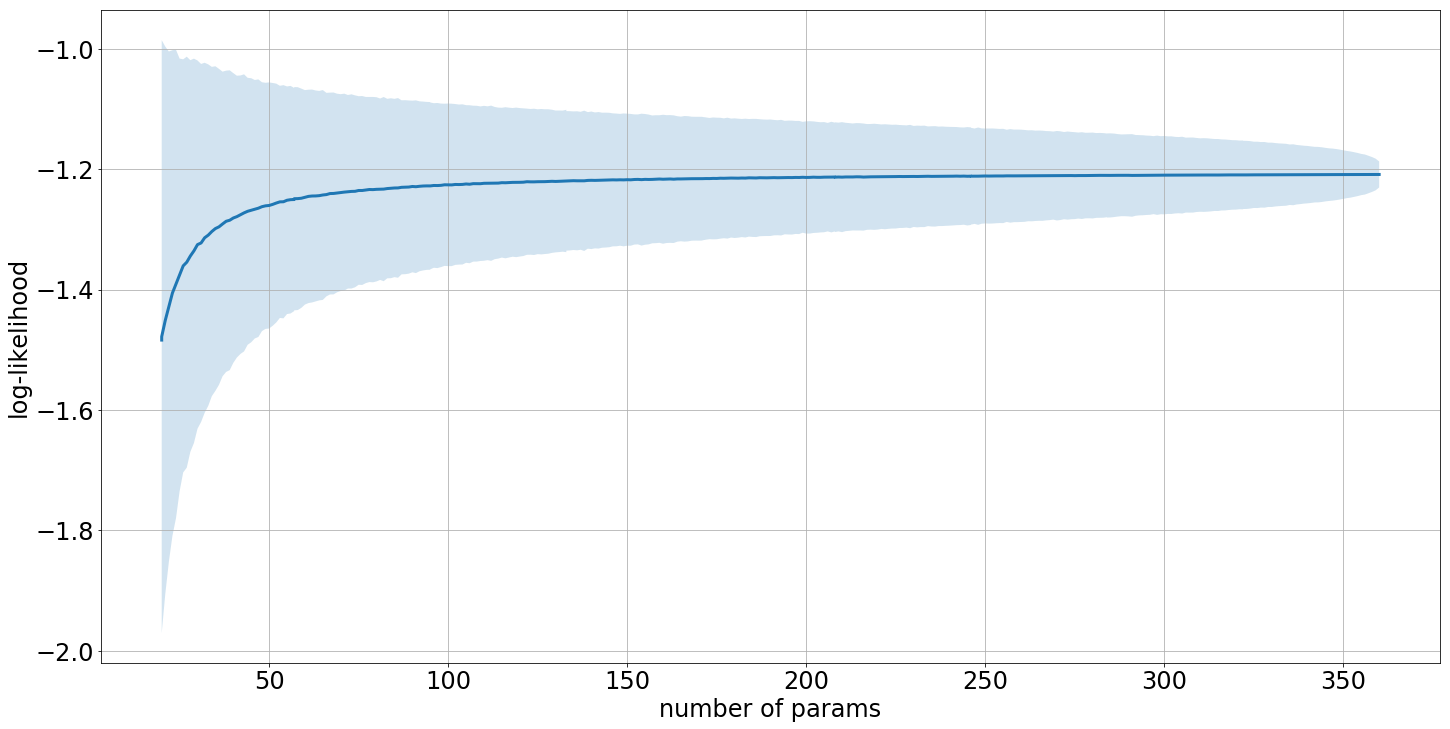

In [41]:
N = 0
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()

## Wine

In [29]:
np.random.seed(5)

dataset = load_wine()
observations = scale(dataset.data)
tg = dataset.target
data = pd.DataFrame(observations)

data['Type'] = tg#(tg - m)/d

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train = shuffle(train)

y_test = test['Type'].values
y_test.reshape([-1])
del test['Type']
X_test = test.values
X_test = np.delete(X_test, np.where(y_test == 2), axis = 0)
y_test = np.delete(y_test, np.where(y_test == 2), axis = 0)

y_train = train['Type'].values
y_train.reshape([-1])
del train['Type']
X_train = train.values
X_train = np.delete(X_train, np.where(y_train == 2), axis = 0)
y_train = np.delete(y_train, np.where(y_train == 2), axis = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(97, 13) (33, 13) (97,) (33,)


In [30]:
print("p-values:\n\n", st.UniformTest(X_train))

p-values:

 [9.35132036e-04 8.45946715e-35 1.21203517e-13 1.31805492e-11
 3.75532909e-13 2.33097382e-10 4.12583513e-13 1.18533796e-08
 1.29037480e-16 1.33339255e-06 4.28662929e-14 3.50840958e-05
 1.01229453e-03]


In [31]:
ordering = OD.features_ordering(X_train, y_train, linear_model='LogisticRegression')

SampleStep = np.linspace(2*X_train.shape[1], X_train.shape[0] - 1, num = 100, dtype=np.int64)

k_for_meaning = 5000

# List_mean, List_std = get_surface(X_train, X_test, y_train, y_test, linear_model = 'LogisticRegression',
#                                   ordering=ordering, position=SampleStep, sigma = sigma, 
#                                   print_progres = True, k_for_meaning=k_for_meaning)

# saved_data = [ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test]
# pickle.dump(saved_data, open("saved_graph/wine5000.p", "wb"))

ordering, SampleStep, List_mean, List_std, X_train, y_train, X_test, y_test = pickle.load(open("saved_graph/wine5000.p", "rb"))


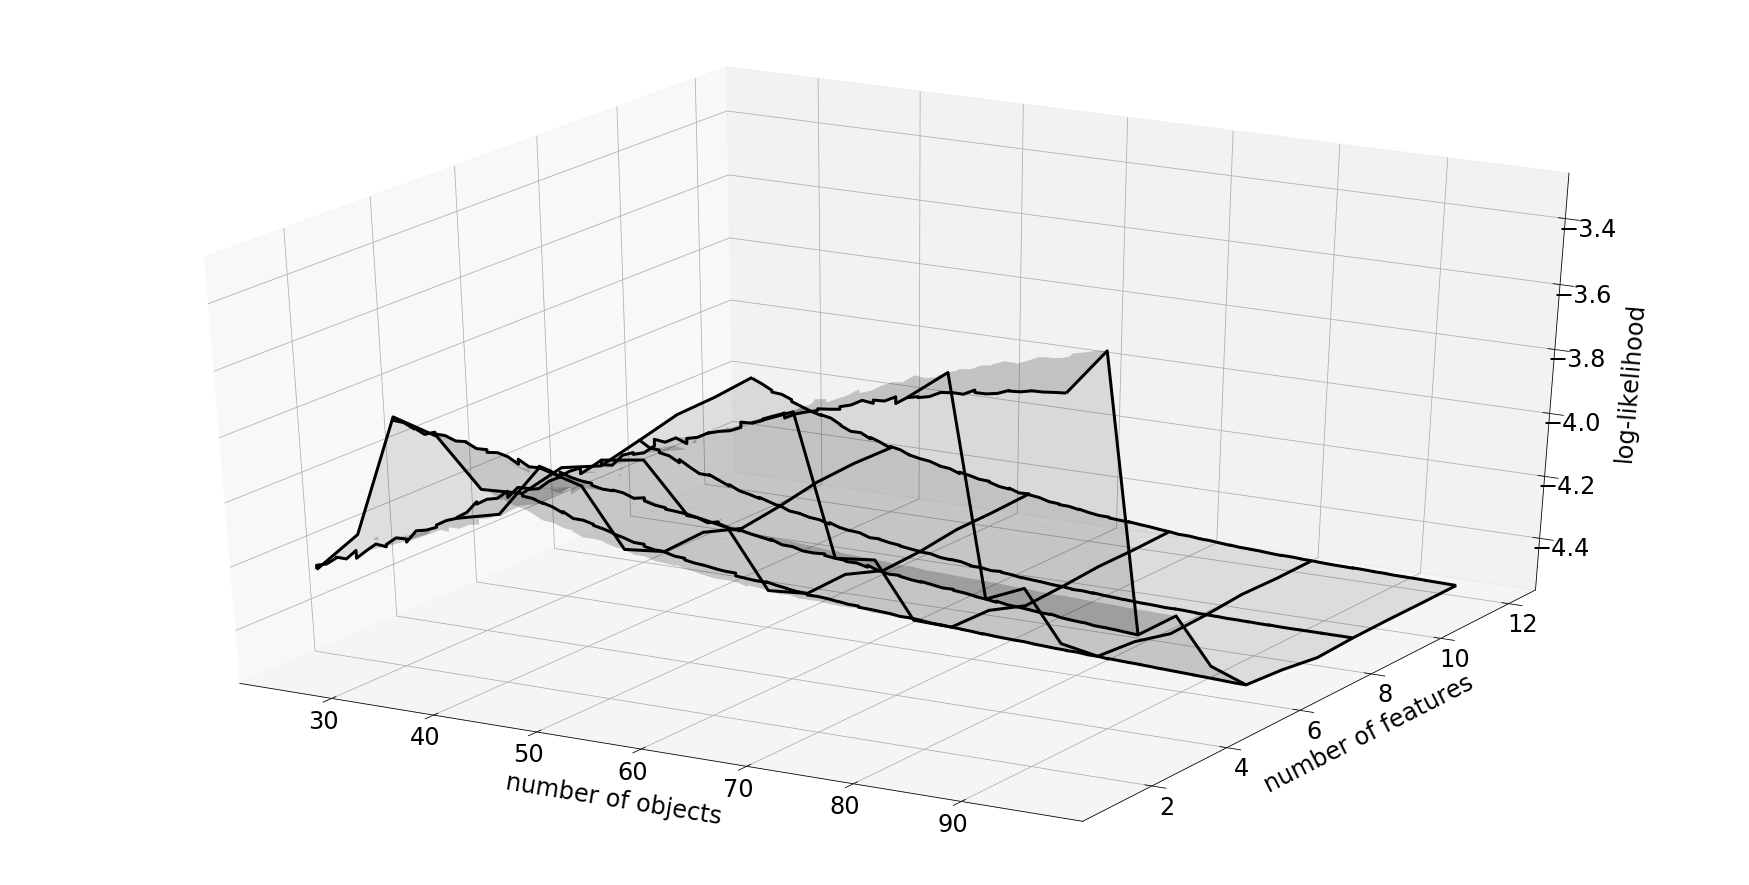

In [32]:
x = SampleStep
y = 1-(np.linspace(0, ordering.shape[0] - 2, ordering.shape[0]-1, dtype = np.int64) - (ordering.shape[0] - 2))

xgrid, ygrid = np.meshgrid(x, y)
zgrid = np.array(List_mean)

fig = plt.figure()
axes = Axes3D(fig)
axes.plot_wireframe(xgrid, ygrid, zgrid, rstride=3, cstride=20, color ='black')
axes.plot_surface(xgrid, ygrid, zgrid, alpha = 0.1, color ='black')

axes.set_xlabel("number of objects", labelpad=30)
axes.set_ylabel("number of features", labelpad=20)
axes.set_zlabel("log-likelihood", labelpad=20)

plt.show()





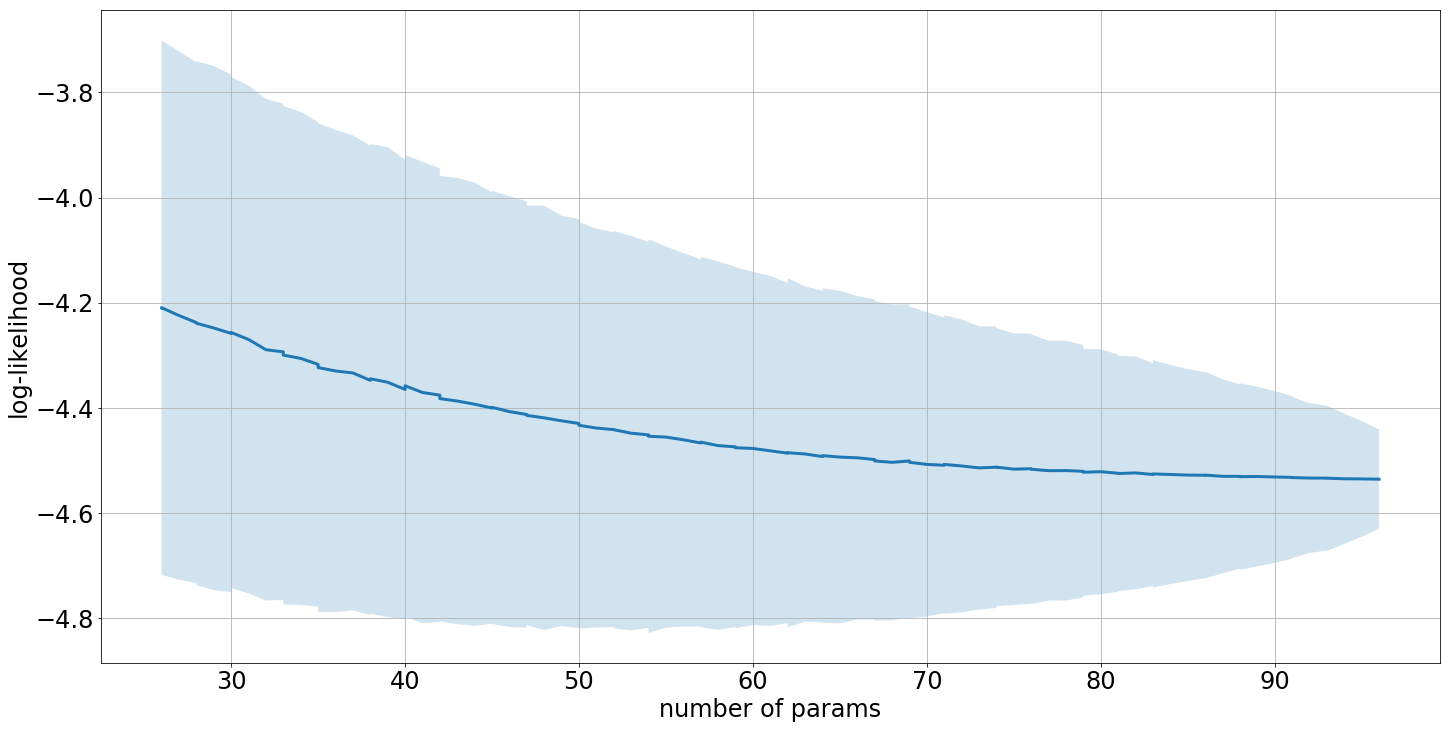

In [33]:
N = 2
mean = List_mean[N]
std = List_std[N]

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean-np.sqrt(std), mean+np.sqrt(std), alpha=0.2)

plt.xlabel('number of params')
plt.ylabel('log-likelihood')
plt.grid()

plt.show()